In [15]:
import scipy
import numpy as np
from fitters import *
from tools import *
from plots import *
from projectors import *
set_seaborn()
sns.set_theme()
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def get_data(Ydataset, factor, Xdataset='PHOTO'):
    resX, stim = read_lmc(Xdataset)
    resY, stim = read_lmc(Ydataset)
    X = preprocess(resX, factor=factor, method='mean')
    Y = preprocess(resY, factor=factor, method='mean')

    return X, Y


In [49]:

def test_run(beta=0, dt_ms=1.0, lag_ms=50, dataset='', method='no_c'):

    factor, dim = convert_dtms_windowms_to_factor_dim(dt_ms, lag_ms)

    X_series, Y_series = get_data(dataset, factor)

    if method == 'no_c':
        P_series, theta, A = eig_companion(X_series, dim, beta=beta)
        w, vl, vr = scipy.linalg.eig(A, left=True, right=True)
    elif method == 'c_shift':
        P_series, theta, A, c = eig_companion_Cshift(X_series, dim, beta=beta)
        w, vl, vr = scipy.linalg.eig(A, left=True, right=True)
    elif method == 'geneig':
        P_series, theta, w, vl = general_eig(X_series, dim, beta=beta)
        vr = vl


    


    theta /= theta[-1] 
    Y_series = Y_series[dim:]
    P_series = solve_scale_shift(P_series, Y_series)

    sortorder = np.argsort(w.real)
    thetas = vl[:, sortorder][:, ::-1]
    thetasR = vr[:, sortorder][:, ::-1]
    w = w[sortorder][::-1]

    thetaR = thetasR[:, 0]
    thetaR /= thetaR[-1]

    time = np.linspace(0, 1, len(X_series))

    # plt.scatter(w.real,w.imag)
    # plt.title(method)
    # plt.show();

    result = {
        'Time-X': time,
        'Time-Y': time[dim:],
        'Time-Filter': np.linspace(-lag_ms, 0, dim),
        'X_series': X_series,
        'Y_series': Y_series,
        'P_series': P_series,
        'Eig Vec (REAL)': theta.real,
        'Eig Vec (IMAG)': theta.imag,
        'Eig Vec (RIGHT)': thetaR.real,
        'Eig Vals (MAG)': np.abs(w),
        'Eig Vals (REAL)': w.real,
        'Eig Vals (IMAG)': w.imag,
        'RIGHT EVs': thetasR,
        'LEFT EVs': thetas,


    }
    return result


In [50]:
ALL_DATA = ['LMC-BG1', 'LMC-BG2', 'LMC-BG3', 'LMC-BG4', 'LMC-BG5', 'LMC-BG6']
params = {
    'dataset': ['LMC-BG1'],
    'beta': [0],
    'dt_ms': [2.0],
    'lag_ms': [30],
    'method': ['no_c', 'c_shift'],

}
results = param_runner(test_run, params)


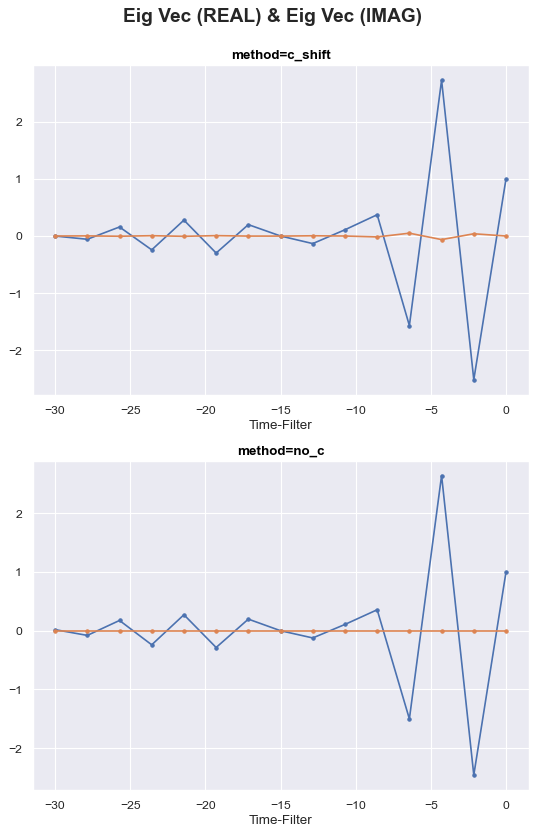

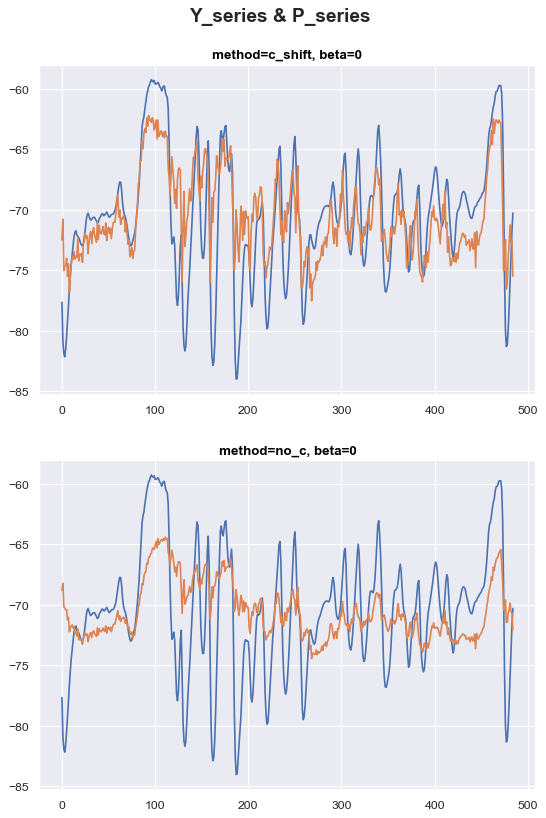

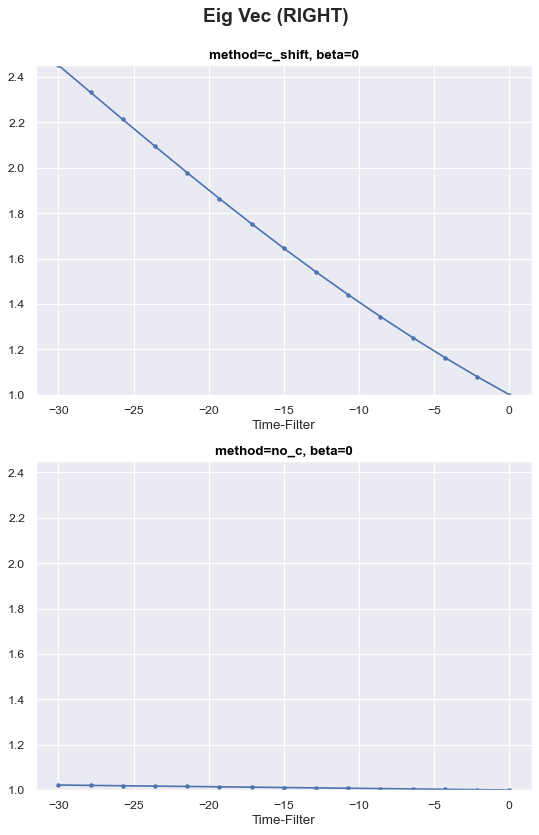

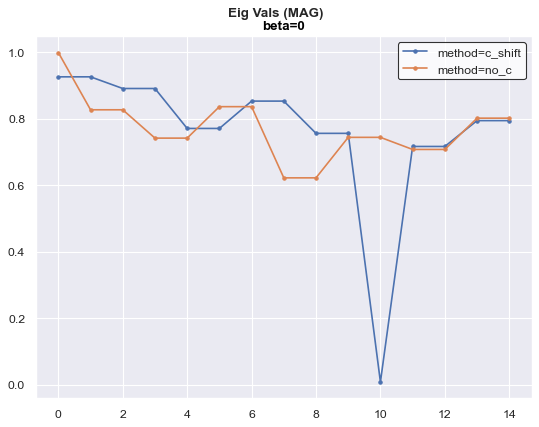

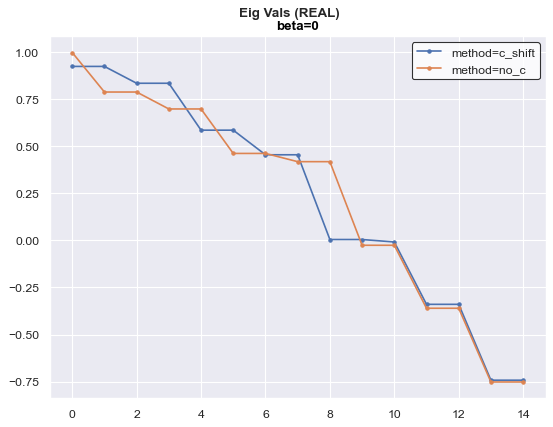

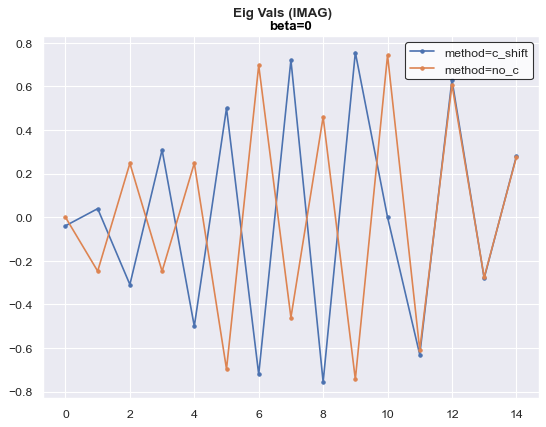

In [51]:
plot_dataframe(results, ['Eig Vec (REAL)','Eig Vec (IMAG)'], x_col='Time-Filter',  title_cols=['method'], val_styles=[['.-']])
# plot_dataframe(results, 'Eig Vec (IMAG)', x_col='Time-Filter', line_cols=['method'],  title_cols=['beta'], val_styles=[['.-']])
plot_dataframe(results, ['Y_series', 'P_series'], title_cols=['method', 'beta'])
plot_dataframe(results, 'Eig Vec (RIGHT)',  x_col='Time-Filter', title_cols=['method', 'beta'], val_styles=[['.-']], fix_yim=True)
plot_dataframe(results, 'Eig Vals (MAG)', line_cols=['method'],  title_cols=['beta'],  val_styles=[['.-']])
plot_dataframe(results, 'Eig Vals (REAL)', line_cols=['method'],   title_cols=['beta'],  val_styles=[['.-']])
plot_dataframe(results, 'Eig Vals (IMAG)', line_cols=['method'],  title_cols=['beta'],  val_styles=[['.-']])


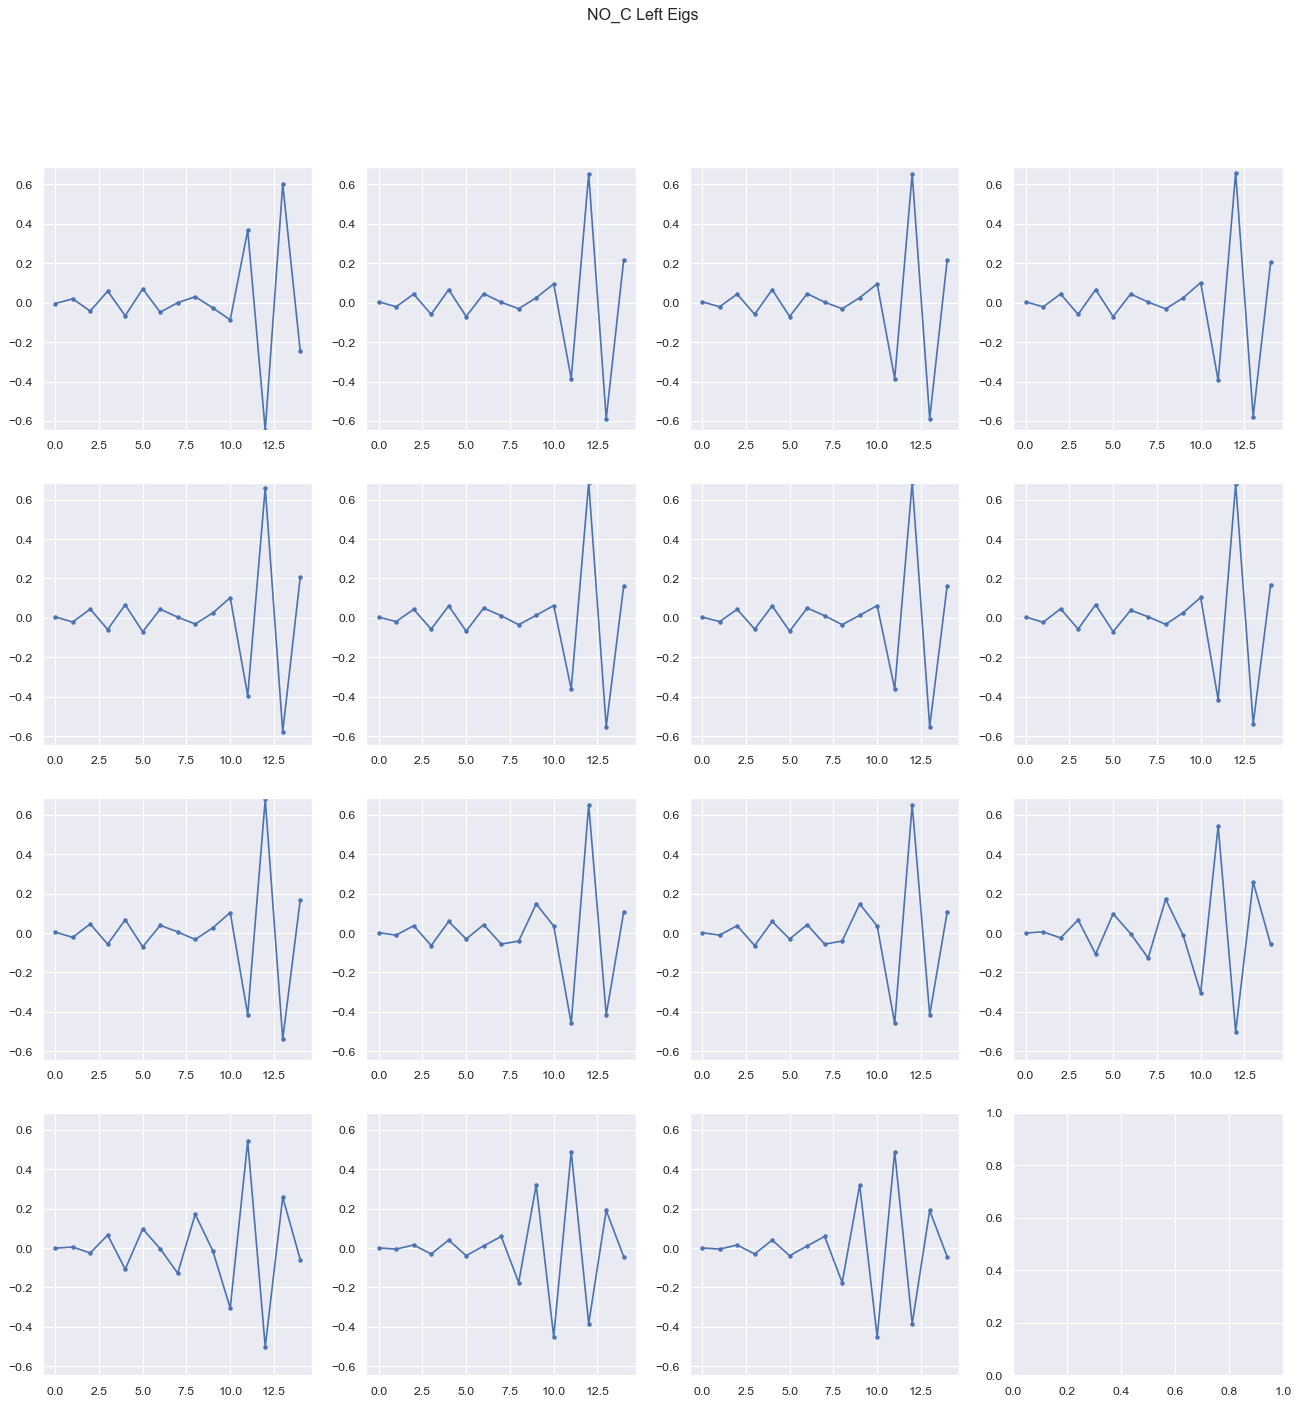

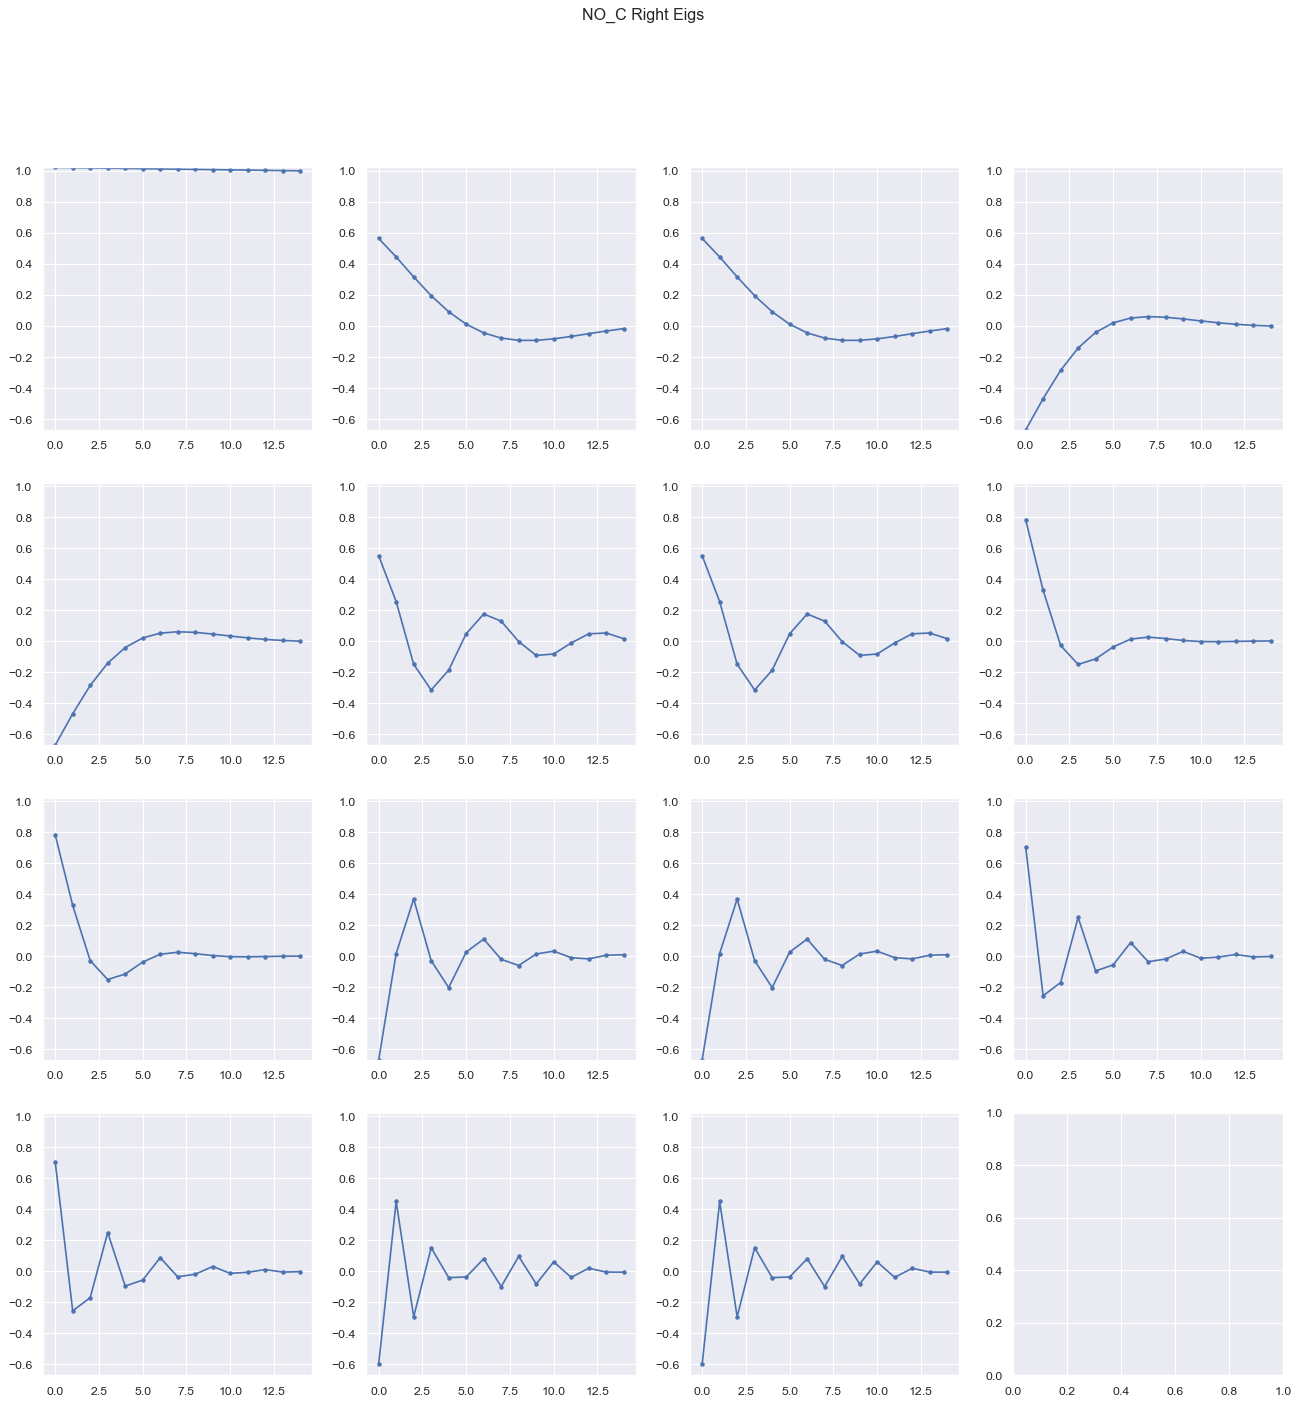

In [26]:
mask = (results['method'] == 'no_c')
cur = results[mask]
left = np.swapaxes(cur['LEFT EVs'].values[0], 0, 1)
right = np.swapaxes(cur['RIGHT EVs'].values[0], 0, 1) 
plot_eigs(left.real, title='NO_C Left Eigs')
plot_eigs(right.real, title='NO_C Right Eigs')

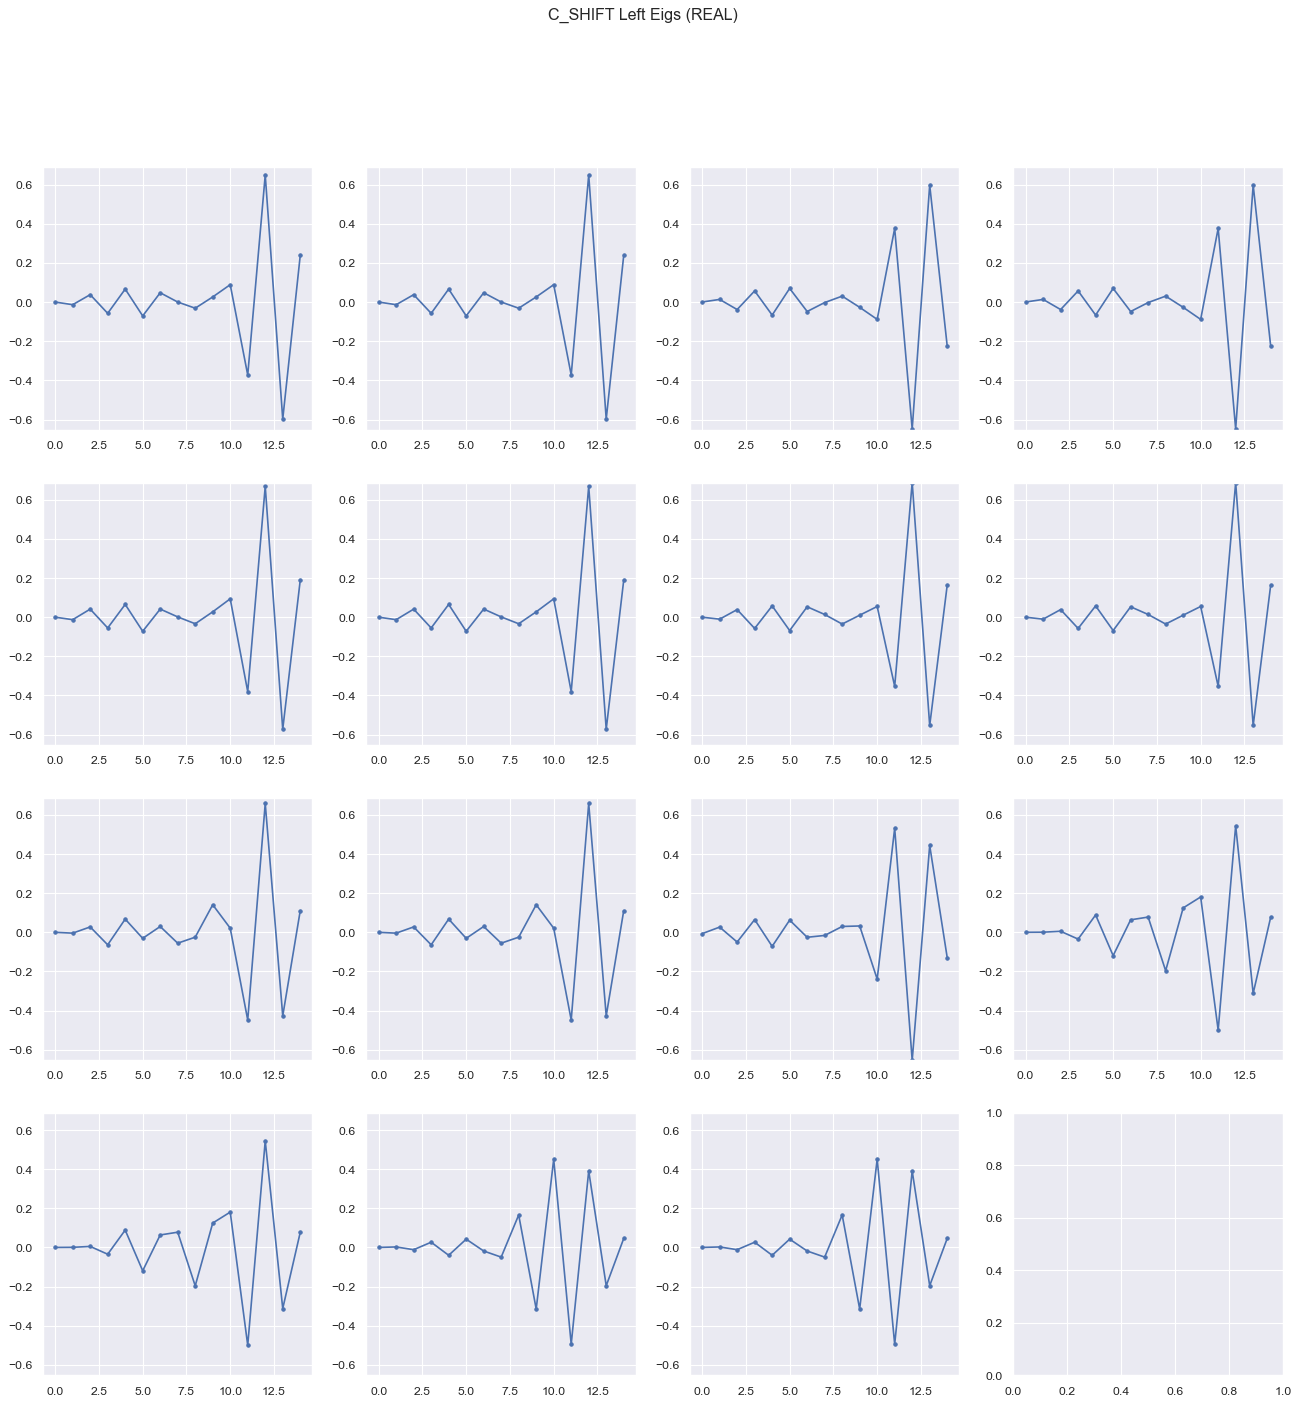

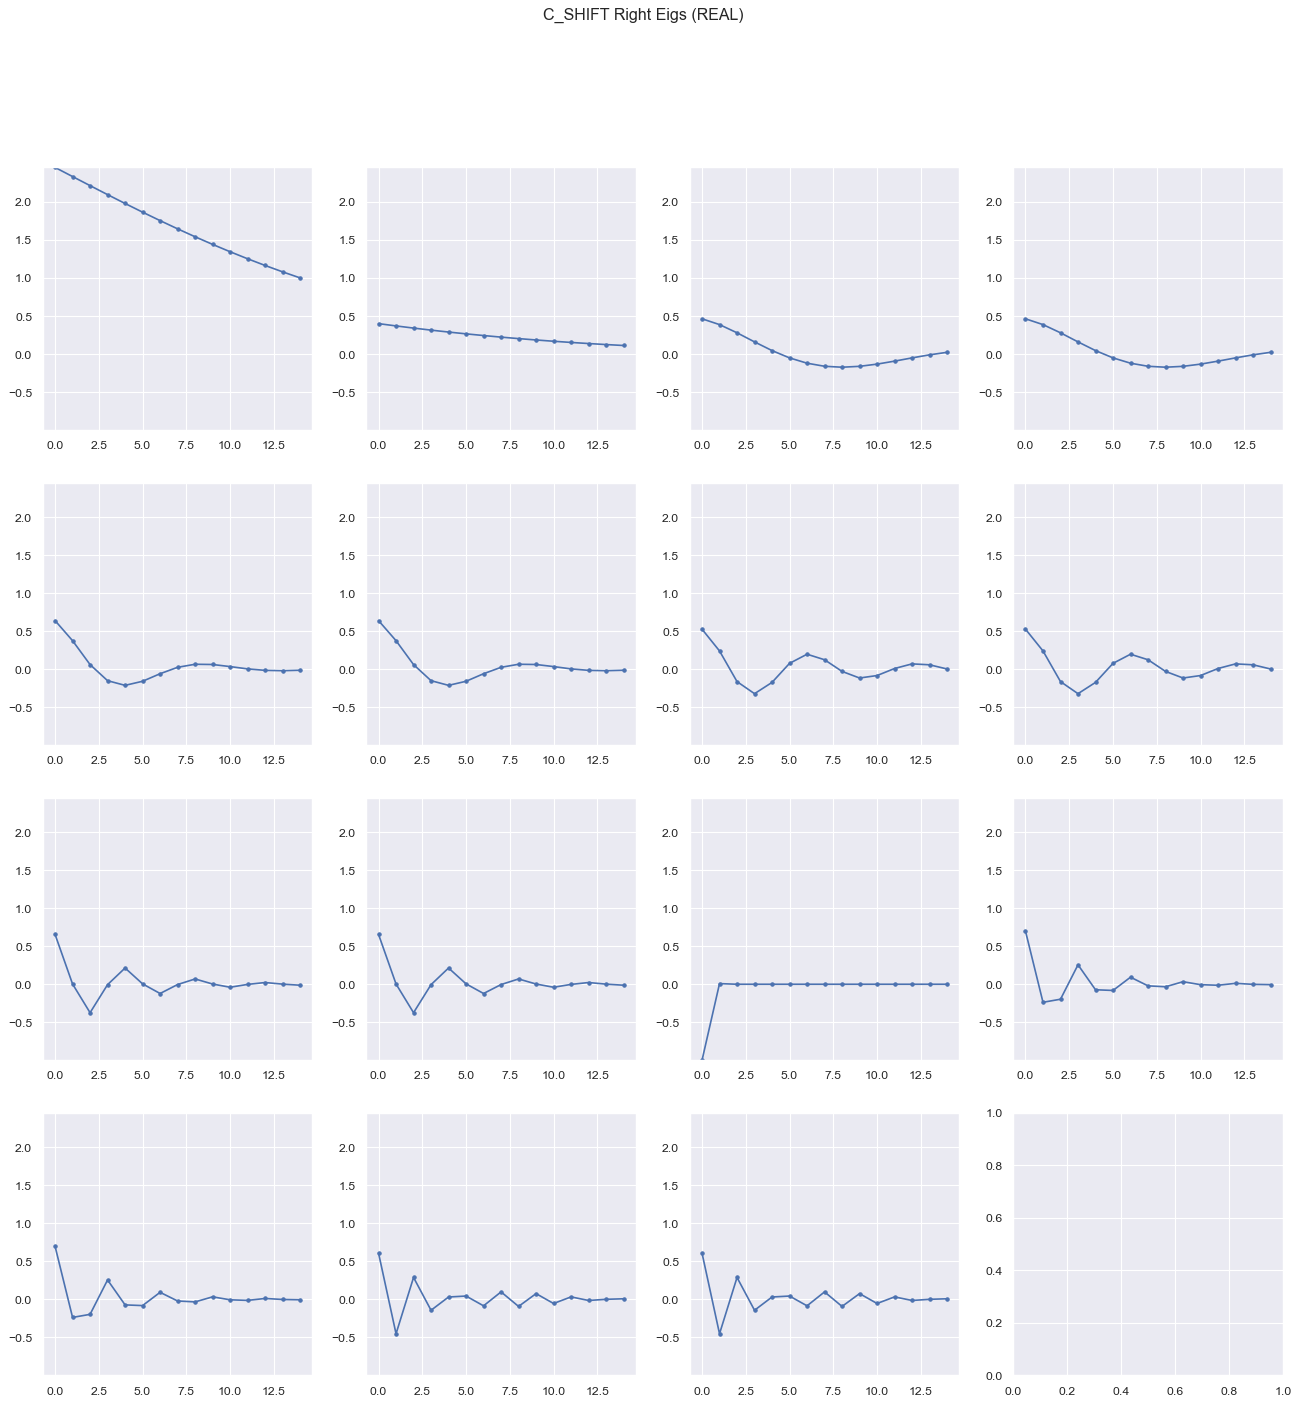

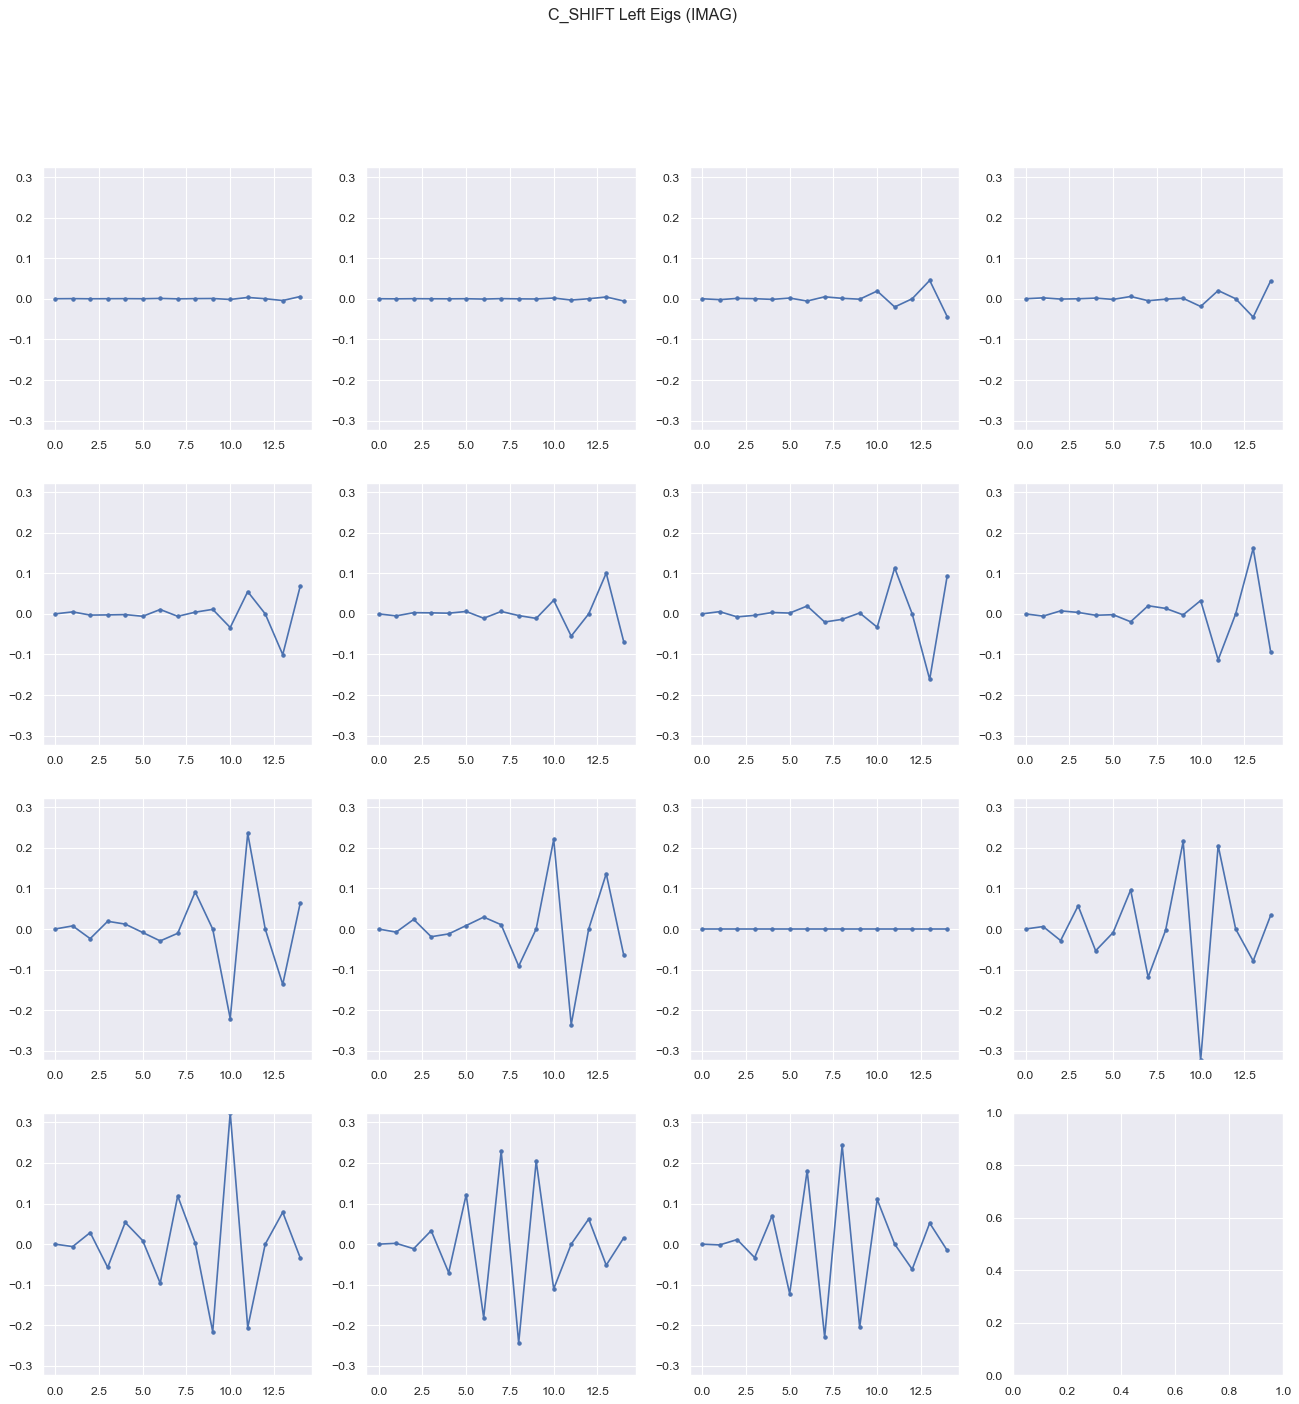

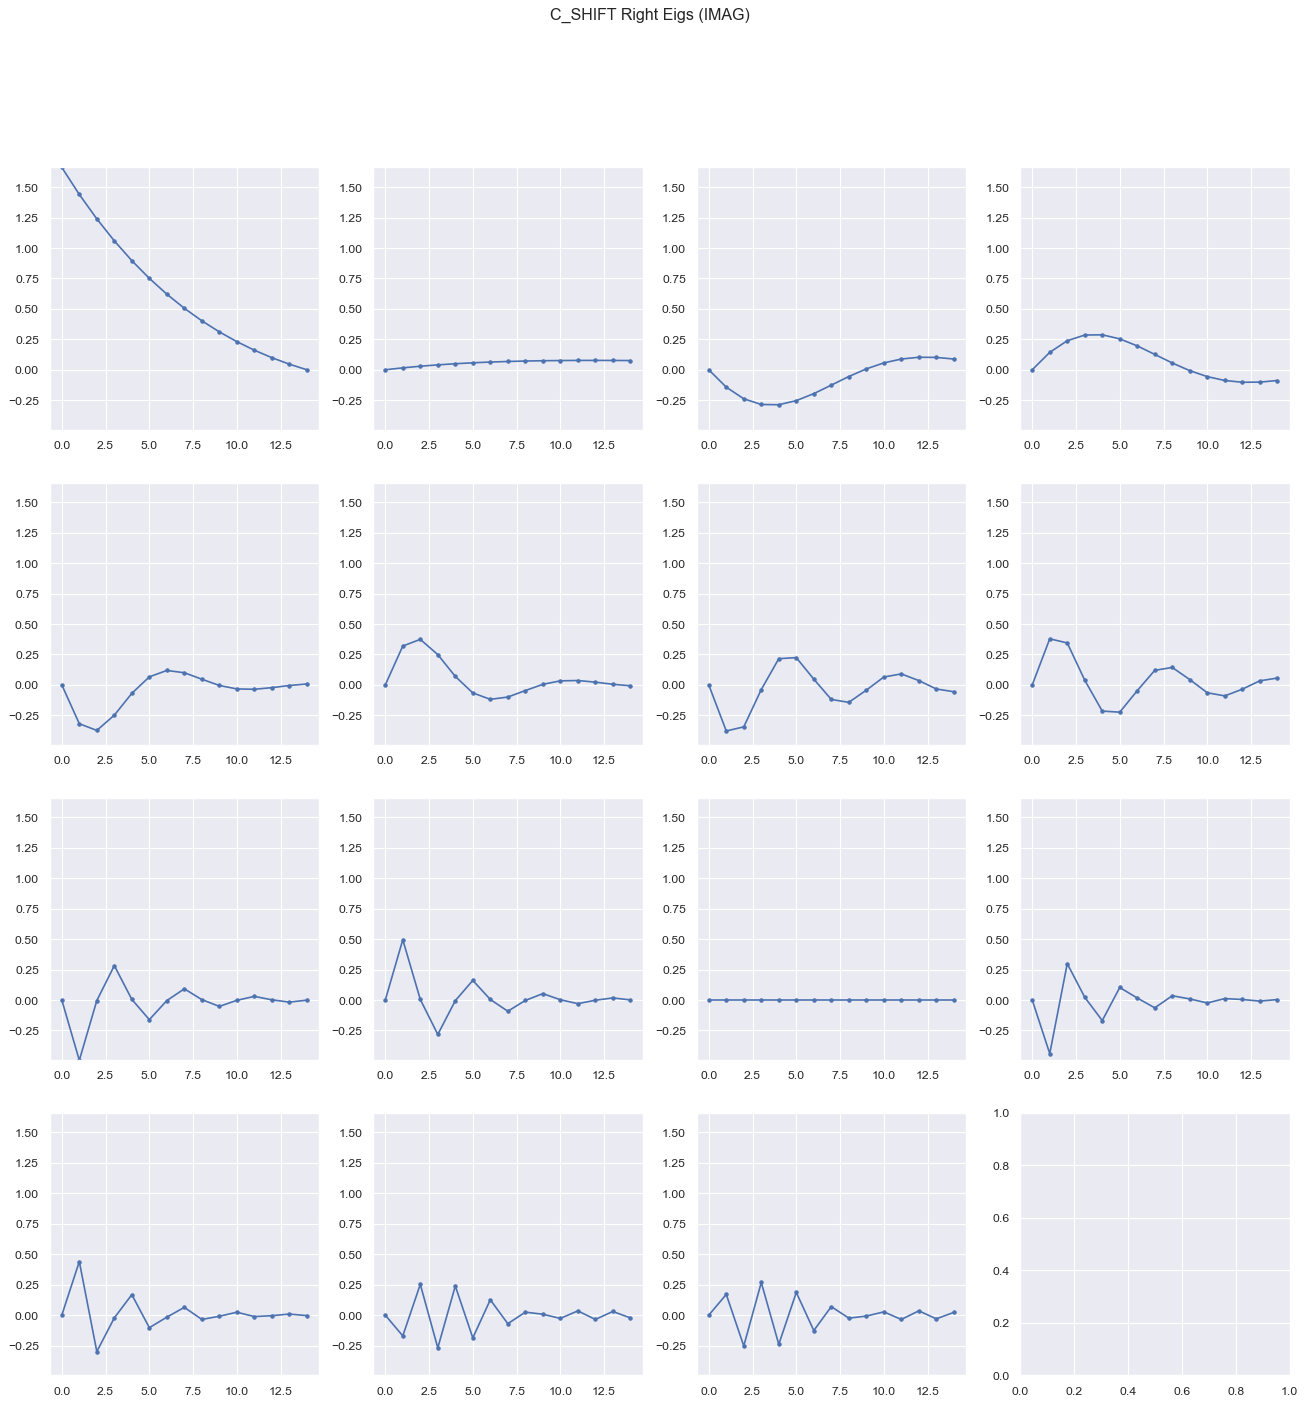

In [27]:
mask = (results['method'] == 'c_shift')
cur = results[mask]
left = np.swapaxes(cur['LEFT EVs'].values[0], 0, 1)
right = np.swapaxes(cur['RIGHT EVs'].values[0], 0, 1) 
plot_eigs(left.real, title='C_SHIFT Left Eigs (REAL)')
plot_eigs(right.real, title='C_SHIFT Right Eigs (REAL)')
plot_eigs(left.imag, title='C_SHIFT Left Eigs (IMAG)')
plot_eigs(right.imag, title='C_SHIFT Right Eigs (IMAG)')